In [1]:
import sys

sys.path.insert(0, '/home/was966/Research/mims-compass/')

from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_sankey_diagram
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")


In [2]:
def plot_gene_ranking(dfa, dfb, sample_cmap = None, use_exvar_for_y =False, top = 10, figsize=(18, 15)):
    """
    Plots the rankings of features across three dataframes with their exvar values.
    
    Parameters:
    dfa, dfb, dfc (pd.DataFrame): Dataframes containing the features and their exvar values.
    cmap (dict): A dictionary mapping features to colors.
    """

    all_features = list(set(dfa.index) | set(dfb.index))

    # 使用Matplotlib的colormap生成鲜艳的颜色
    num_features = len(all_features)

    positions = {'a': 1, 'b': 2,}
    

    fig, ax = plt.subplots(figsize=figsize)
    

    # 对每个数据帧的特征按exvar值进行排序，获取排名
    sorted_indices_a = dfa['abs_shap'].sort_values(ascending=True).index
    sorted_indices_b = dfb['abs_shap'].sort_values(ascending=True).index

    top10_verlap = list(set(sorted_indices_a[-top:]) | set(sorted_indices_b[-top:]) )

    top = 10

    #top10_verlap = sorted_indices_b[-top:]
    #top10_verlap = dfb[dfb['exvar'] > 0.1].index
    if sample_cmap is None:
        x1 = dfa['abs_shap'].rank()
        x2 = dfb['abs_shap'].rank()
        sub = x1 > x2
        sample_cmap = sub.map({True:'b', False:'r'})

    for feature in all_features:
        feature_color = sample_cmap[feature]

        # 绘制圆点及其标准差阴影，Y位置由exvar值决定
        if use_exvar_for_y:
            a_exvar = dfa.loc[feature, 'abs_shap'] if feature in dfa.index else None
            b_exvar = dfb.loc[feature, 'abs_shap'] if feature in dfb.index else None

    
            if a_exvar is not None:
                ax.scatter(positions['a'], a_exvar, s=a_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['a'], a_exvar, s=(a_exvar + dfa.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')
            if b_exvar is not None:
                ax.scatter(positions['b'], b_exvar, s=b_exvar * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['b'], b_exvar, s=(b_exvar + dfb.loc[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.2, edgecolor='none')


            if a_exvar is not None and b_exvar is not None:
                ax.annotate("", xy=(positions['b'], b_exvar), xytext=(positions['a'], a_exvar),
                             arrowprops=dict(arrowstyle="->, head_width=0.3, head_length=0.5", color=feature_color, lw=1.5))

            vals = ax.get_yticks()
            ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
            ax.text(positions['b']+0.05, b_exvar, feature)
            
        else:
            # 获取在每个数据帧中的排名
            a_rank = np.where(sorted_indices_a == feature)[0][0] if feature in dfa.index else None
            b_rank = np.where(sorted_indices_b == feature)[0][0] if feature in dfb.index else None

            
            
            # 绘制圆点及其标准差阴影
            if a_rank is not None:
                ax.scatter(positions['a'], a_rank, s=dfa.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['a'], a_rank, s=(dfa.at[feature, 'abs_shap'] + dfa.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')
            if b_rank is not None:
                ax.scatter(positions['b'], b_rank, s=dfb.at[feature, 'abs_shap'] * 2000, marker='o', color=feature_color, alpha=0.7)
                ax.scatter(positions['b'], b_rank, s=(dfb.at[feature, 'abs_shap'] + dfb.at[feature, 'std']) * 4000, marker='o', color=feature_color, alpha=0.4, edgecolor='none')

            # 绘制箭头
            if feature in top10_verlap:
                if a_rank is not None and b_rank is not None:
    
                    #ac = 'red' if a_rank > b_rank else 'blue'
                    ac = feature_color
                    ax.annotate("", xy=(positions['b'], b_rank), xytext=(positions['a'], a_rank),
                                 arrowprops=dict(arrowstyle="->, head_width=0.2, head_length=0.5", color=ac, lw=0.5, ls = '-'))

            plt.yticks(np.arange(dfa.shape[0]), sorted_indices_a)


    ax.tick_params(axis='both', which='major', right = False, top=True, bottom=False, direction = 'out',reset = True)
    plt.xticks([1, 2], ['Pretraining', 'Partial Finetuning'])
    plt.tick_params(axis='x', labeltop=True, labelbottom=False)
    
    #plt.title('Feature Ranking with Exvar and Std')
    #plt.xlabel('IMVigor210 cohort')
    if not use_exvar_for_y:
        plt.ylabel('Ranking')
    else:
        plt.ylabel('Weights')
    plt.grid(True, linestyle='--', color='#dddddd')


    if not use_exvar_for_y:
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        # 如果sorted_indices_c的长度与ax.get_yticks()返回的刻度数相同，则可以直接设置
        ax2.set_yticks(ax.get_yticks())
        # 如果sorted_indices_c是字符串列表，包含特征名称，可以直接赋值
        ax2.set_yticklabels(sorted_indices_b)

        
        
    # Legend for exvar sizes (as percentages)
    # Create custom legend
    # for i, size in enumerate(np.linspace(0.1, 0.5, 5)):
    #     ax.scatter([], [], s=size * 1000, color='black', alpha=0.3, edgecolor='grey', label=f'{size * 100:.0f}%')

    #ax.legend(title='Explained Var.', bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0., fancybox=True)
    fig.tight_layout()    
    return fig


In [28]:
cancer_1 = 'KIRC'
cancer_2 = 'SKCM'

In [29]:
concept_imp_dict1 = pd.read_csv('./results/%s_shap_pft_r.csv' % cancer_1, index_col=0).abs().mean().sort_values()
concept_imp_dict1 = 10*concept_imp_dict1/concept_imp_dict1.sum()


concept_imp_dict2 = pd.read_csv('./results/%s_shap_pft_r.csv' % cancer_2, index_col=0).abs().mean().sort_values()
concept_imp_dict2 = 10*concept_imp_dict2/concept_imp_dict2.sum()



### LFT model
df1_r = pd.read_csv('./All_shap_lft_r.csv', index_col=0)
df1_nr = pd.read_csv('./All_shap_lft_nr.csv', index_col=0)


### PFT model
df2_r = pd.read_csv('./All_shap_pft_r.csv', index_col=0)
df2_nr = pd.read_csv('./All_shap_pft_nr.csv', index_col=0)

df1 = df1_r.abs().mean().to_frame('R').join(df1_nr.abs().mean().to_frame('NR'))
df2 = df2_r.abs().mean().to_frame('R').join(df2_nr.abs().mean().to_frame('NR'))

dfa = df1.mean(axis=1).sort_values().to_frame('abs_shap')
dfa = dfa.join(df1.std(axis=1).sort_values().to_frame('std'))

dfb = df2.mean(axis=1).sort_values().to_frame('abs_shap')
dfb = dfb.join(df2.std(axis=1).sort_values().to_frame('std'))

# y1_order = dfa.sort_values('abs_shap').index
# y2_order = dfb.sort_values('abs_shap').index

# top = 50
# used_concept = list(set(y1_order[-top:]) | set(y2_order[-top:]) )

# dfa = dfa.loc[used_concept]
# dfb = dfb.loc[used_concept]


In [30]:
concept2plot=concept_imp_dict2.keys() #'Genome_integrity', 'Endothelial'] #'Cytotoxic_Tcell', 'Exhausted_Tcell', 'Monocyte', 'Epithelial'

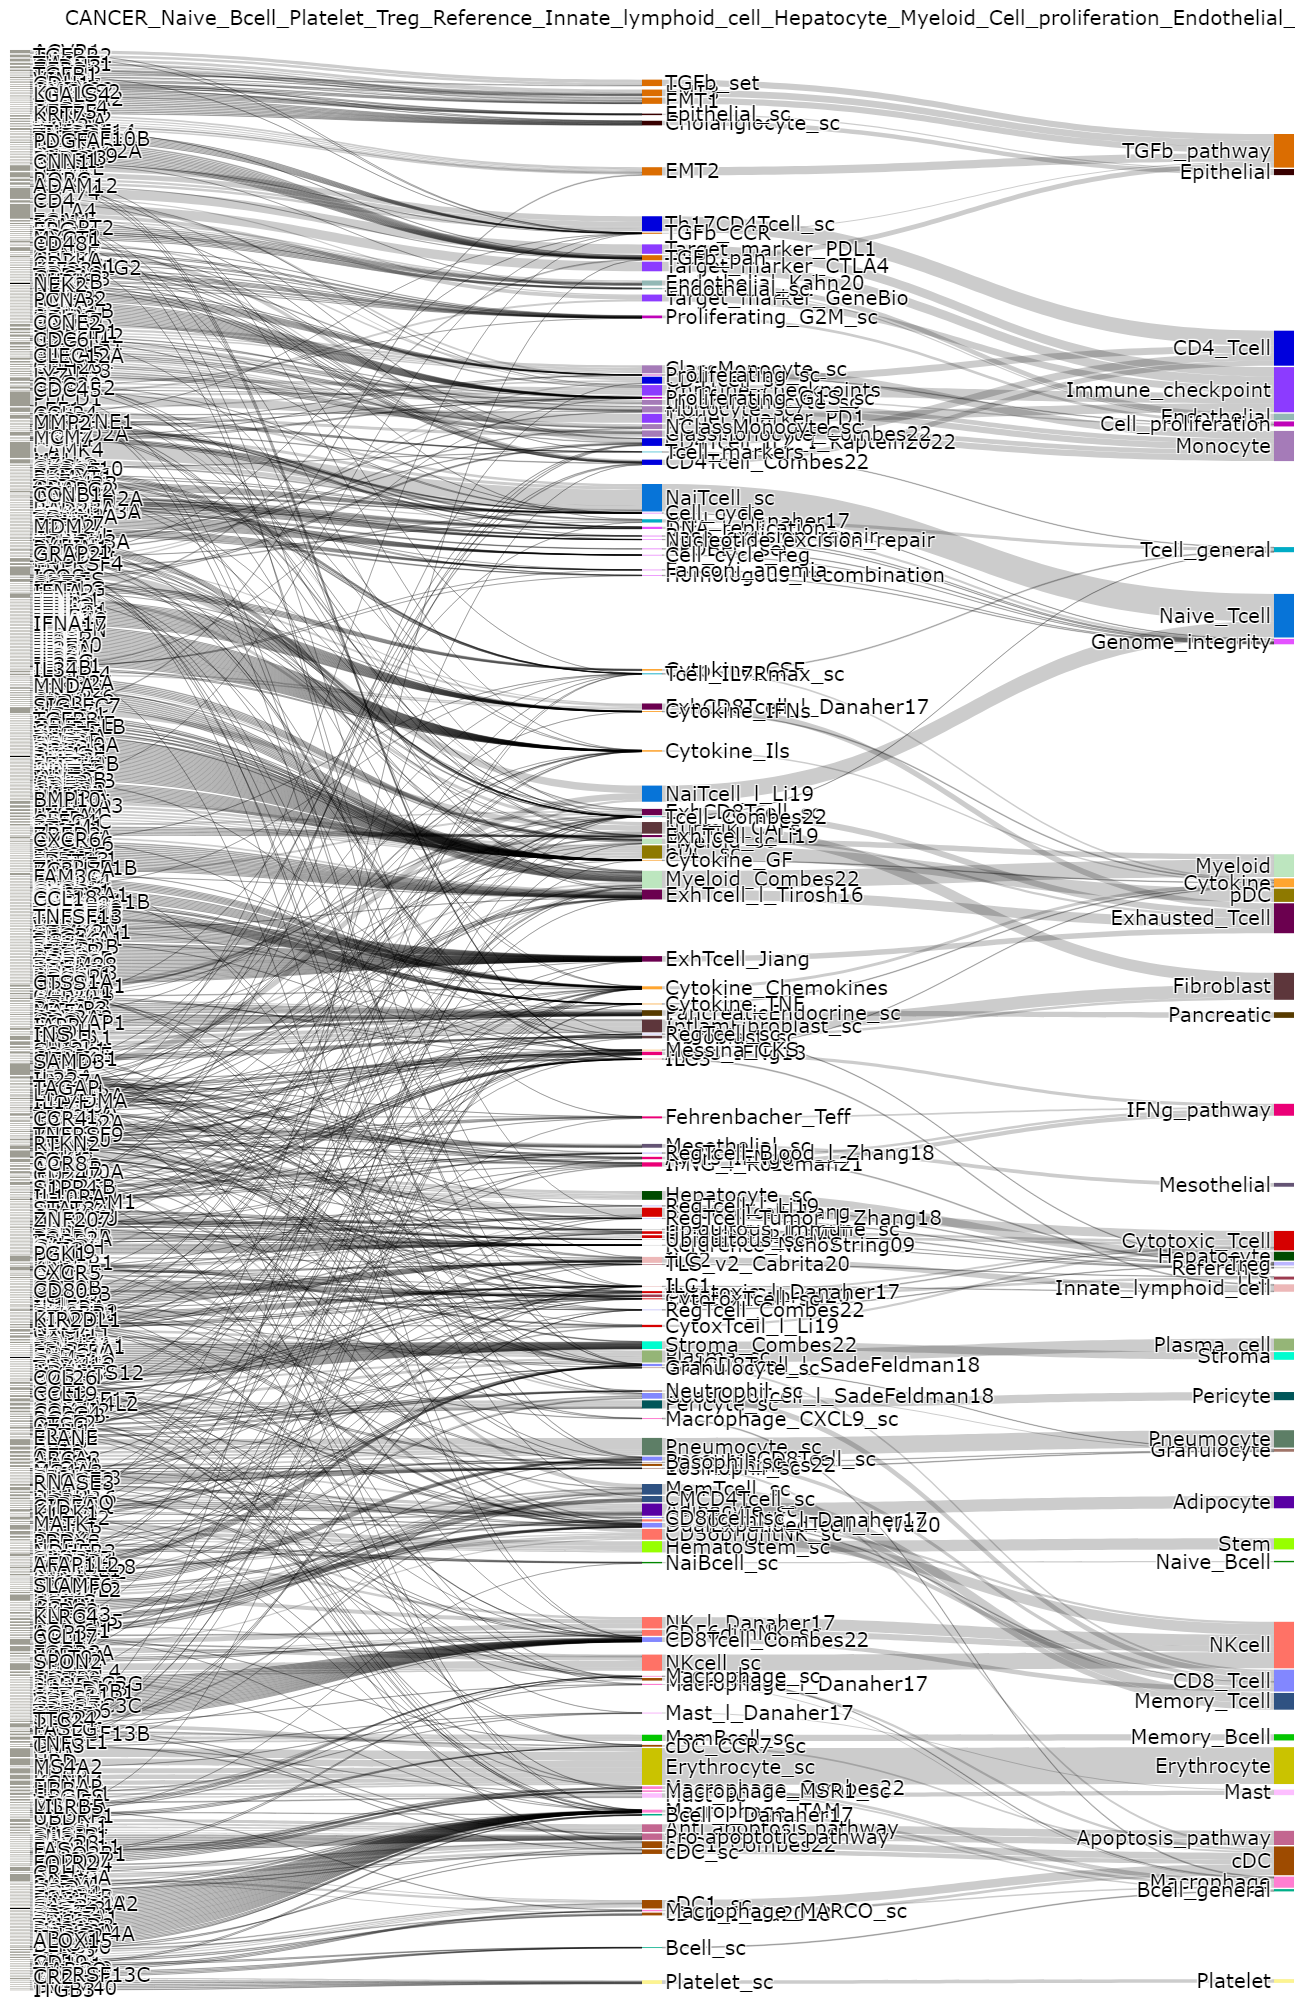

In [31]:
model1_path = '/home/was966/Research/mims-compass/paper//checkpoint/latest/finetuner_pft_%s.pt' % cancer_1
model1 = loadcompass(model1_path)
df1, fig1 = plot_sankey_diagram(model1,  concept2plot=concept2plot, height = 2000, concept_imp_dict = concept_imp_dict1, font=dict(size=20, color='black')) #concept_imp_dict = concept_imp_dict1,
fig1

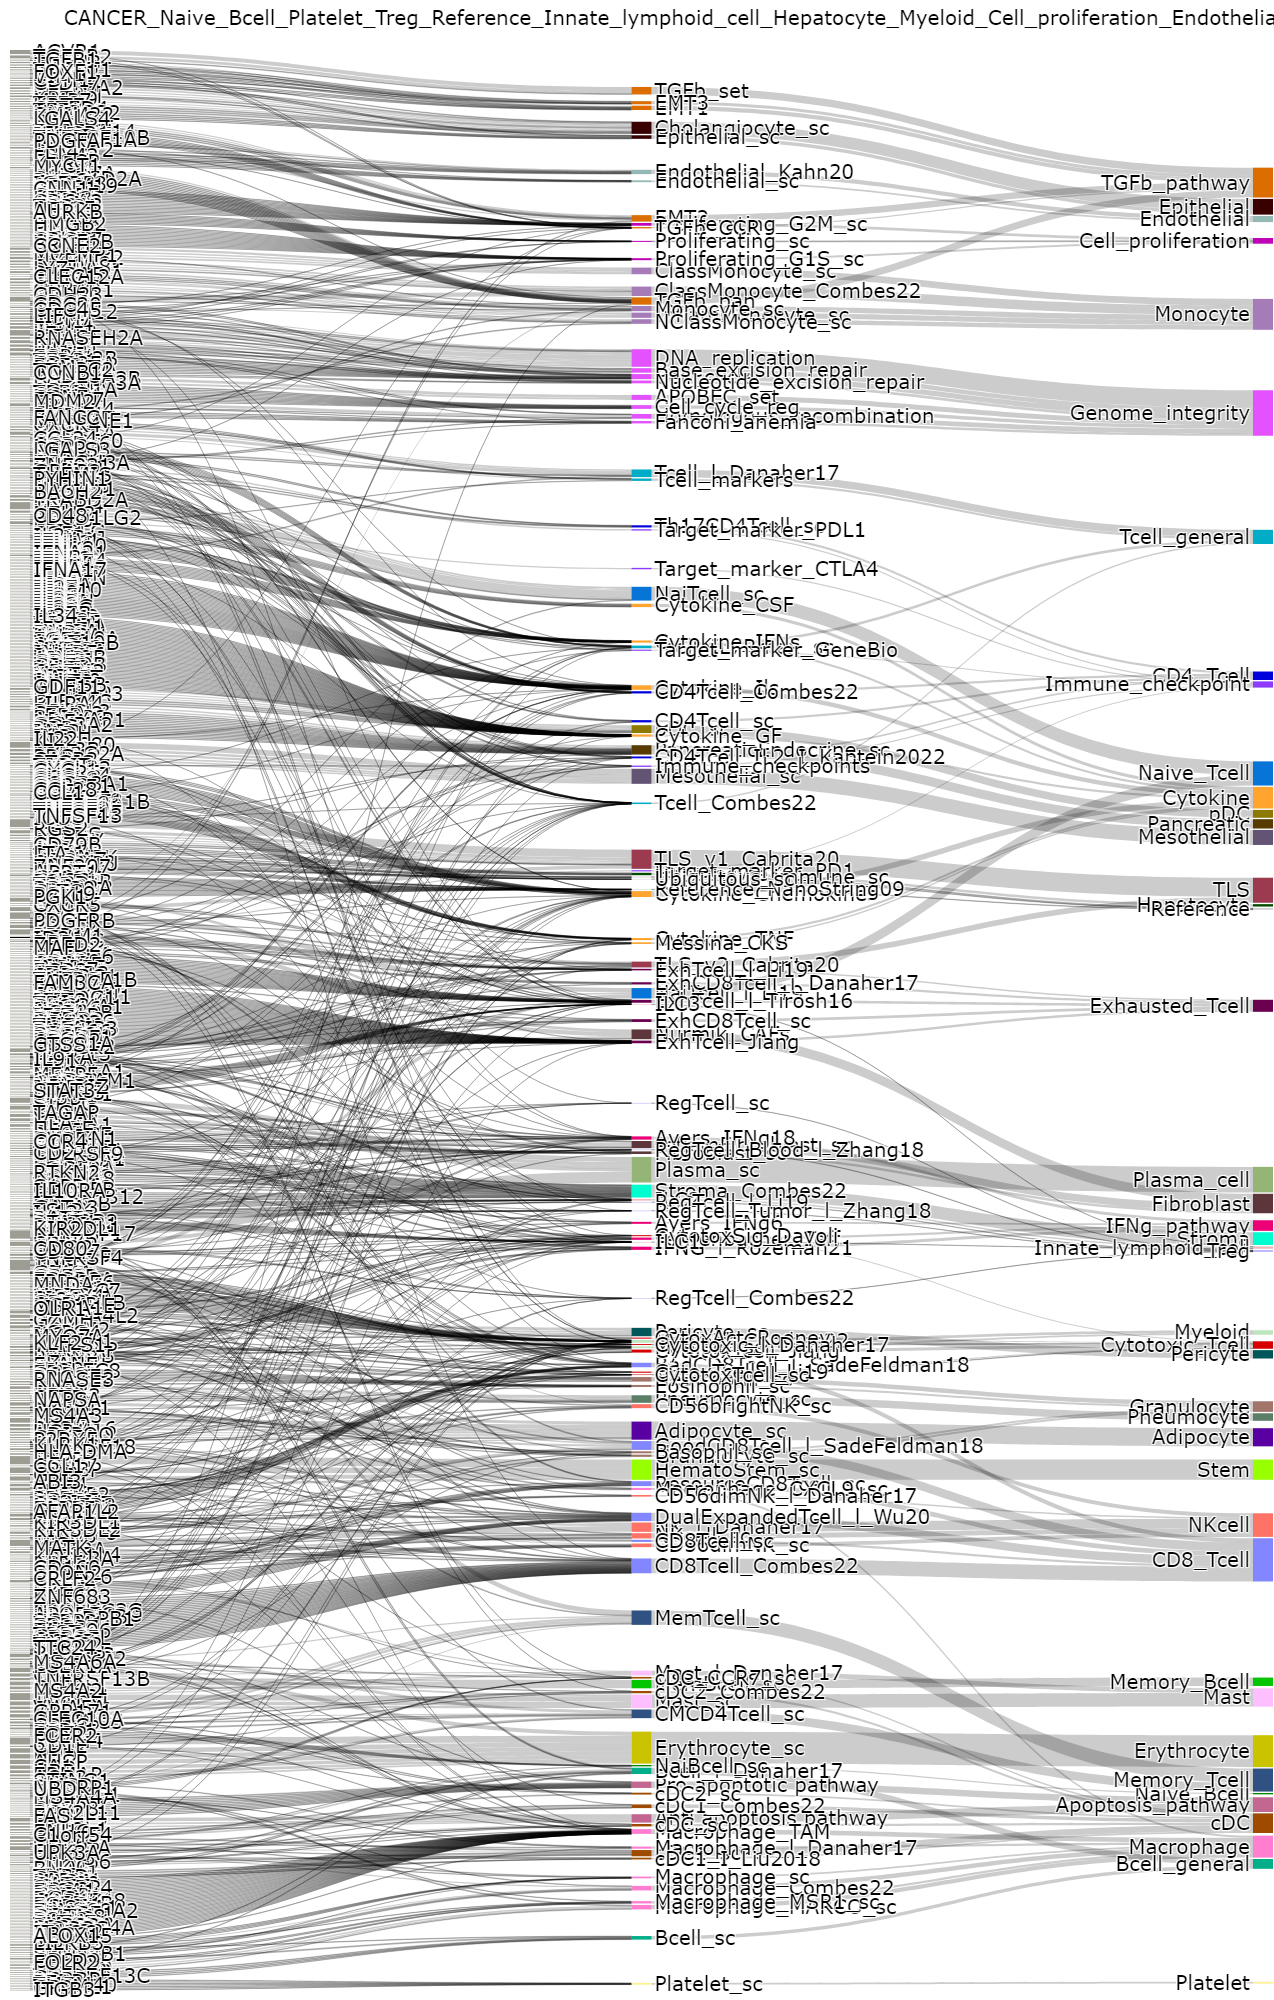

In [32]:
model2_path = '/home/was966/Research/mims-compass/paper/checkpoint/latest/finetuner_pft_%s.pt' % cancer_2
model2 = loadcompass(model2_path)
df2, fig2 = plot_sankey_diagram(model2, reverse=False, concept2plot= concept2plot, concept_imp_dict = concept_imp_dict2, height = 2000, #concept_imp_dict = concept_imp_dict2, 
                               font=dict(size=20, color='black'),  )
fig2

In [47]:
df1

source                  target   weights              group  \
0   Bcell_l_Danaher17           Bcell_general  0.022968  geneset->celltype   
1            Bcell_sc           Bcell_general  0.011924  geneset->celltype   
0                 BLK       Bcell_l_Danaher17  0.002194      gene->geneset   
1                CD19       Bcell_l_Danaher17  0.001283      gene->geneset   
2               MS4A1       Bcell_l_Danaher17  0.001841      gene->geneset   
..                ...                     ...       ...                ...   
13              RPL19  Reference_NanoString09  0.000144      gene->geneset   
14              RPLP0  Reference_NanoString09  0.000267      gene->geneset   
15               SDHA  Reference_NanoString09  0.000493      gene->geneset   
16                TBP  Reference_NanoString09  0.000252      gene->geneset   
17               TUBB  Reference_NanoString09  0.000239      gene->geneset   

          concept source_color target_color  
0   Bcell_general      #00af89      #00af89  
1   Bcell_general      #00af89      #00af89  
0   Bcell_general      #9e9d93      #00af89  
1   Bcell_general      #9e9d93      #00af89  
2   Bcell_general      #9e9d93      #00af89  
..            ...          ...          ...  
13      Reference      #9e9d93      #d3d3d3  
14      Reference      #9e9d93      #d3d3d3  
15      Reference      #9e9d93      #d3d3d3  
16      Reference      #9e9d93      #d3d3d3  
17      Reference      #9e9d93      #d3d3d3  

[1415 rows x 7 columns]

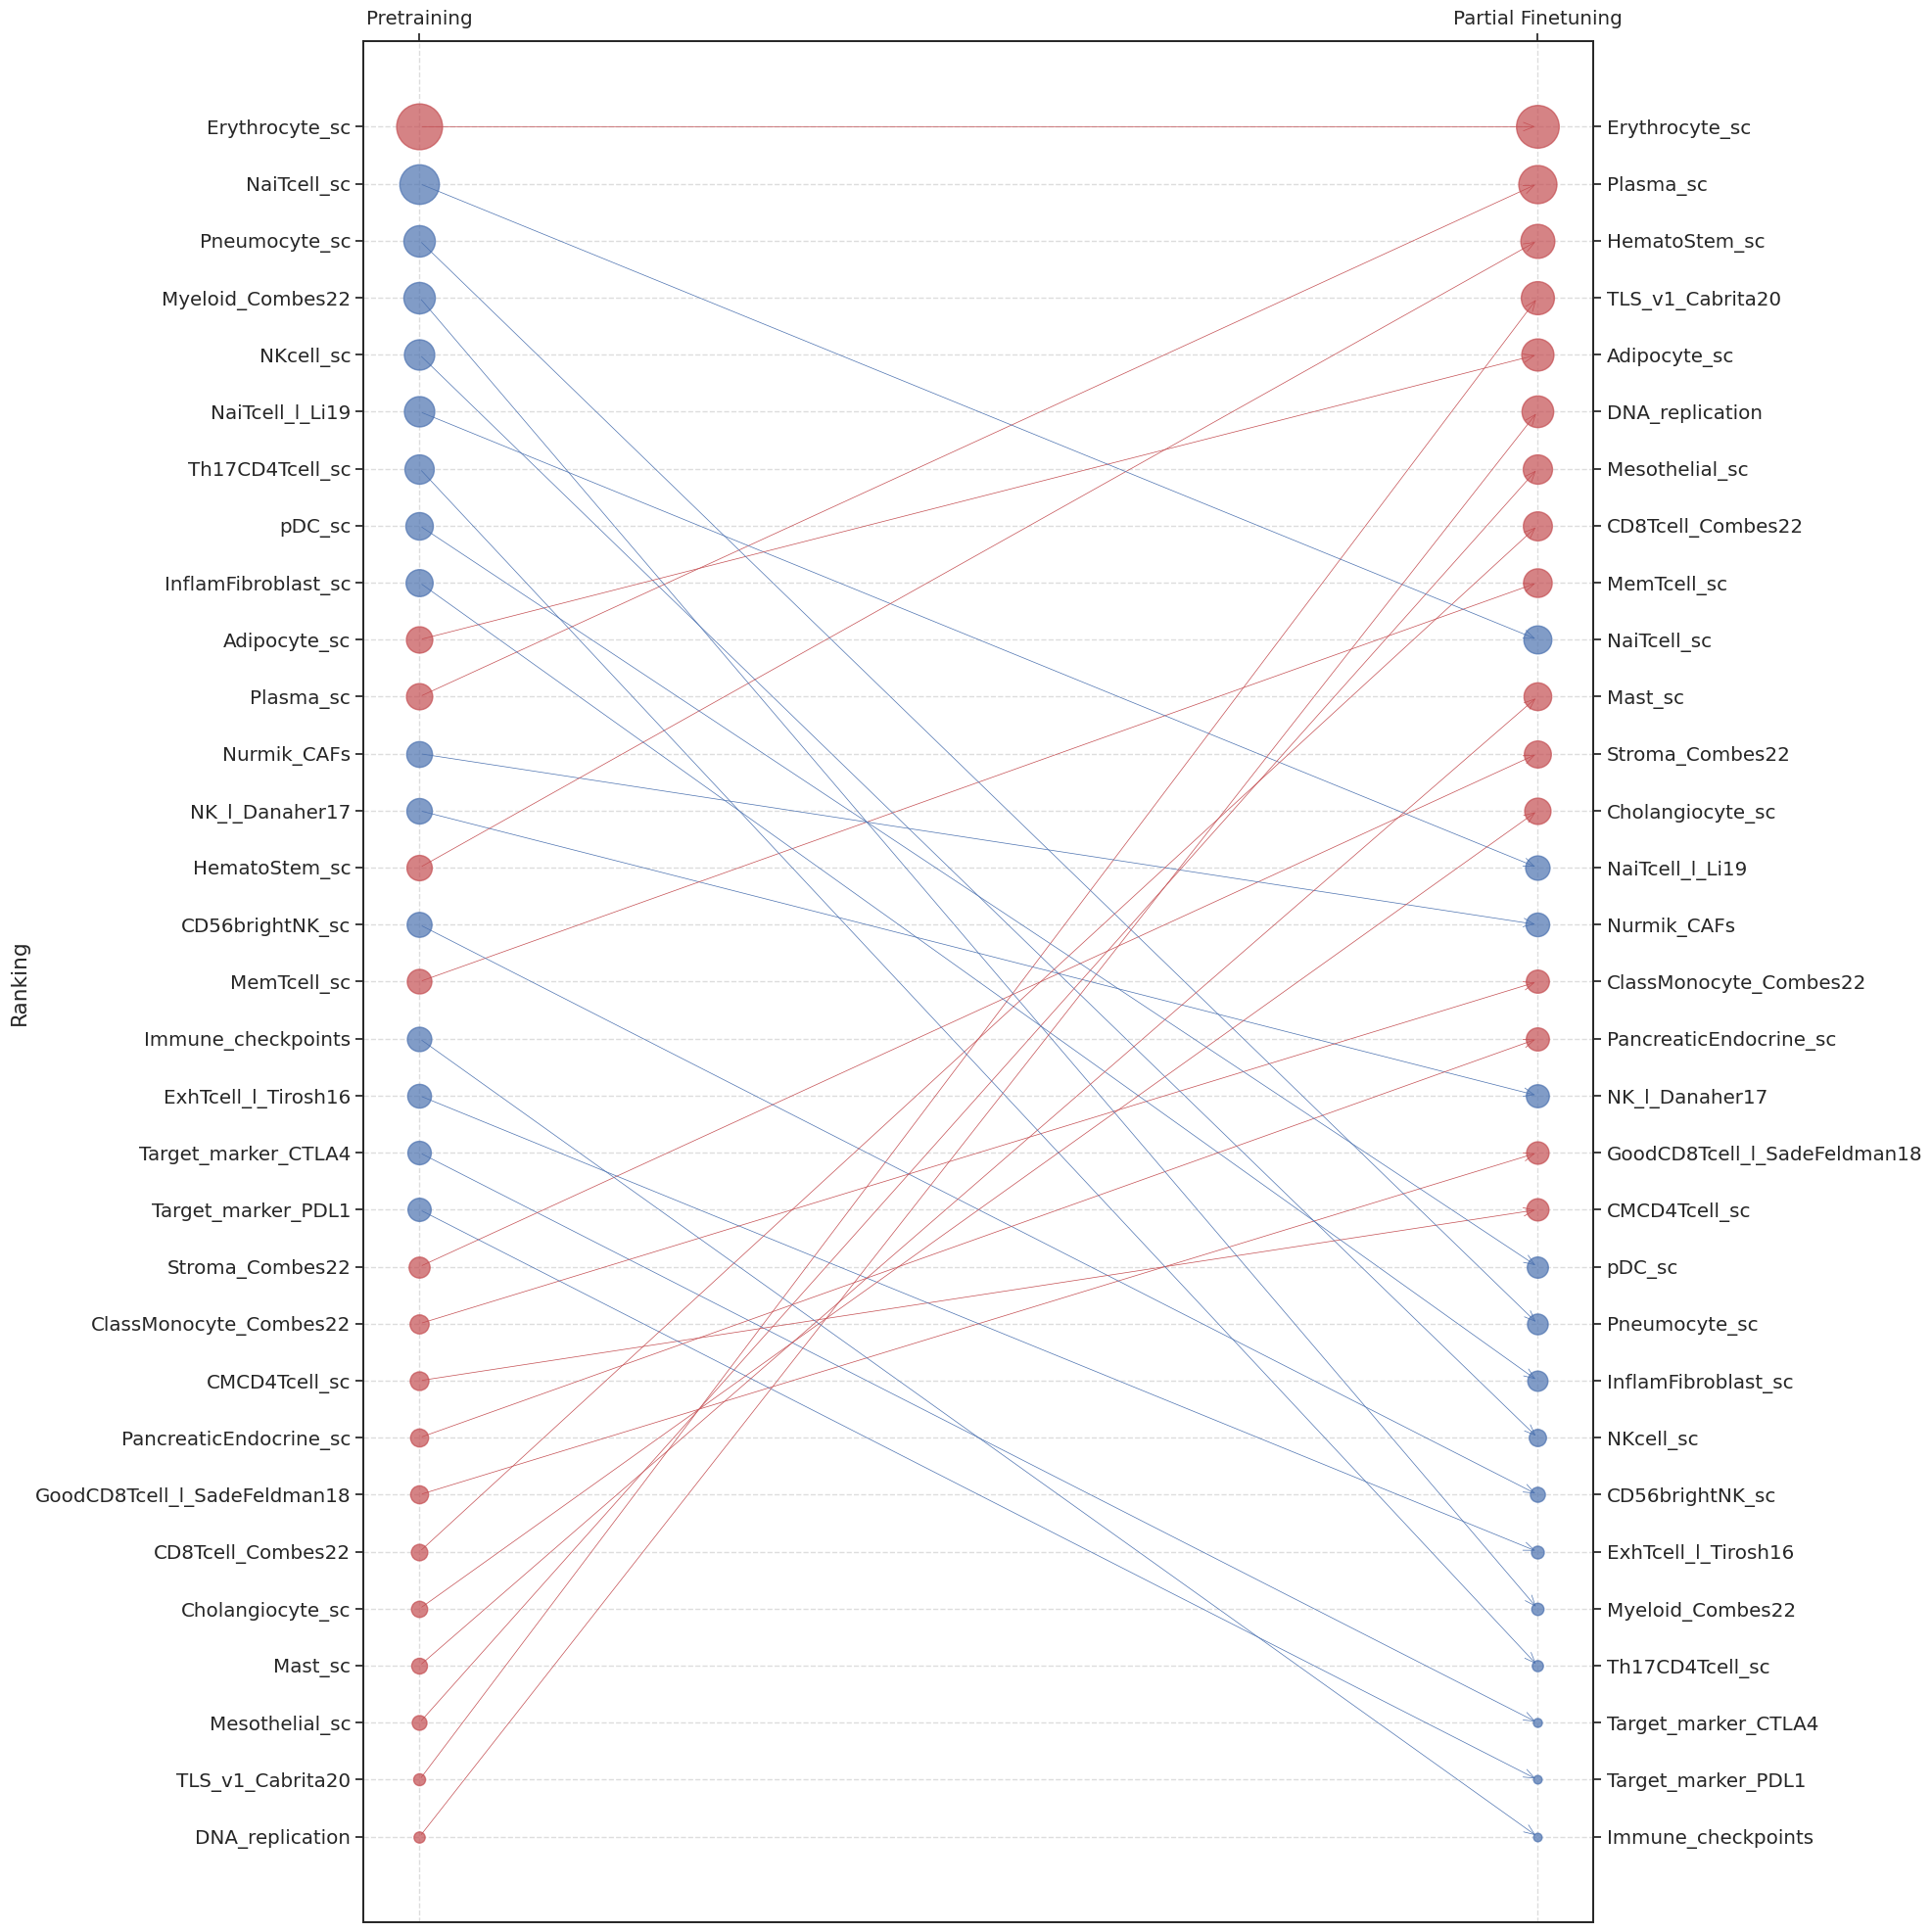

In [49]:
dfa = df1.groupby(['group', 'source']).weights.sum().reset_index()
dfa = dfa[ dfa.group == 'geneset->celltype'].set_index('source').weights.to_frame('abs_shap')
dfa['std'] = np.nan

dfb = df2.groupby(['group', 'source']).weights.sum().reset_index()
dfb = dfb[ dfb.group == 'geneset->celltype'].set_index('source').weights.to_frame('abs_shap')
dfb['std'] =  np.nan

used_genes = list(set(dfa.sort_values('abs_shap').tail(20).index) | set(dfb.sort_values('abs_shap').tail(20).index))

dfa = dfa.loc[used_genes]
dfb = dfb.loc[used_genes]

fig = plot_gene_ranking(dfa, dfb, None,  use_exvar_for_y = False, top = -1, figsize=(20, 20))
fig.savefig('./results/col2_y_var.pdf',bbox_inches  = 'tight')